<a href="https://colab.research.google.com/github/Chai-T29/Video_Audio_SentimentAnalysis/blob/main/0_Loading_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data for RAVDESS Emotion Classification
This scipt is used to setup our data for the project.

### Importing Libraries and Data
If you wish to recreate this project, you will need to sign up for an API key from the following website:
https://zenodo.org/records/1188976

In [1]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

import requests
import os
from tqdm.notebook import tqdm
import zipfile
import cv2
import numpy as np
import gc
from io import BytesIO
import tempfile
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive
ACCESS_TOKEN = userdata.get('api_key') # add your own api key here
record_id = '1188976'

response = requests.get(f'https://zenodo.org/api/records/{record_id}', params={'access_token': ACCESS_TOKEN})
data = response.json()

/content/drive/MyDrive


In [4]:
all_files = data['files']
speech_files = []
song_files = []
for d in all_files:
    components = d['key'].split('_')
    if components[1] == 'Speech':
        speech_files.append(d)
    else:
        song_files.append(d)
os.makedirs('Speech', exist_ok=True)

for file in tqdm(speech_files):
    file_url = file['links']['self']
    file_name = os.path.join('Speech', file['key'])

    if not os.path.exists(file_name):
        response = requests.get(file_url, params={'access_token': ACCESS_TOKEN})
        with open(file_name, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded: {file_name}")

print("Download complete.")

  0%|          | 0/25 [00:00<?, ?it/s]

Download complete.


### Creating Training and Testing Data
Once we have downloaded our data from Zenodo's website, we can start extracting necessary data from each of the zip files. Here's a basic overview of the methodology:

1. Access each Actor's zip file, and process all the videos without sound.
2. Resize each of the frames by a scale factor ($\frac{1}{3}$) and interpolote the frames by a desired frame count ($50$).
3. Join these compressed videos together for each actor's zip file and randomly access $40$ indeces for training and $20$ for testing.
4. Merge the training and testing tensors, and save them to disk.

In [ ]:
def resize_frame(frame, scale_factor):
    """Resizes a frame by a given scale factor."""

    height, width = frame.shape[:2]
    new_dimensions = (int(width * scale_factor), int(height * scale_factor))
    resized_frame = cv2.resize(frame, new_dimensions, interpolation=cv2.INTER_AREA)
    return resized_frame

def interpolate_frames(frames, target_frame_count):
    """Interpolates frames to a given frame count."""

    original_frame_count = len(frames)
    if original_frame_count == target_frame_count:
        return frames

    indices = np.linspace(0, original_frame_count - 1, target_frame_count)
    interpolated_frames = []
    for i in indices:
        lower_index = int(np.floor(i))
        upper_index = int(np.ceil(i))
        if lower_index == upper_index:
            interpolated_frames.append(frames[lower_index])
        else:
            lower_weight = upper_index - i
            upper_weight = i - lower_index
            interpolated_frame = (lower_weight * frames[lower_index] + upper_weight * frames[upper_index]).astype(np.uint8)
            interpolated_frames.append(interpolated_frame)

    return interpolated_frames

def video_to_array(video_bytes, target_frame_count, scale_factor):
    """Converts a video file to an array of frames."""

    with tempfile.NamedTemporaryFile(delete=False) as temp_video:
        temp_video.write(video_bytes.read())
        temp_video_path = temp_video.name

    cap = cv2.VideoCapture(temp_video_path)

    if not cap.isOpened():
        print(f'Error: Could not open video.')
        return None

    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_frame = resize_frame(frame, scale_factor)
        frames.append(resized_frame)

    cap.release()
    os.remove(temp_video_path)

    interpolated_frames = interpolate_frames(frames, target_frame_count)
    video_array = np.stack(interpolated_frames).transpose(1, 2, 3, 0)

    del interpolated_frames
    del frames
    gc.collect()

    return video_array

def process_zip_file(zip_path, target_frame_count, scale_factor, train_size):
    """Processes a zip file and returns training and testing tensors."""

    tensors_shape = (int(720*scale_factor), int(1280*scale_factor), 3, target_frame_count, 60)
    video_tensors = np.zeros(tensors_shape, dtype=np.uint8)
    identifier = np.zeros((60, 7), dtype=np.uint8)

    i = 0
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_info in tqdm(zip_ref.infolist()):
            file_name = file_info.filename.split('/')[1]
            if (file_name.startswith('02')) and (file_name.endswith('.mp4')):
                try:
                    with zip_ref.open(file_info) as video_file:
                        video_bytes = BytesIO(video_file.read())
                        video_tensor = video_to_array(video_bytes, target_frame_count, scale_factor)

                        if video_tensor is not None:
                            id = np.array(file_name[:-4].split('-'), dtype=np.uint8)
                            identifier[i, :] = id
                            video_tensors[:, :, :, :, i] = video_tensor

                            del file_name
                            del video_bytes
                            del video_tensor
                            del id
                            gc.collect()

                except Exception as e:
                    print(f"Failed to process {file_info.filename}: {e}")
                i += 1

    permutation = np.random.permutation(i)
    training_indices = permutation[:train_size]
    all_indices = np.arange(i)
    testing_indices = np.array([j for j in all_indices if j not in training_indices])

    training_tensor = video_tensors[:, :, :, :, training_indices]
    testing_tensor = video_tensors[:, :, :, :, testing_indices]
    del video_tensors
    gc.collect()

    training_identifier = identifier[training_indices, :]
    testing_identifier = identifier[testing_indices, :]
    del identifier
    gc.collect()

    return training_tensor, training_identifier, testing_tensor, testing_identifier

Total Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Processing Video_Speech_Actor_02.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


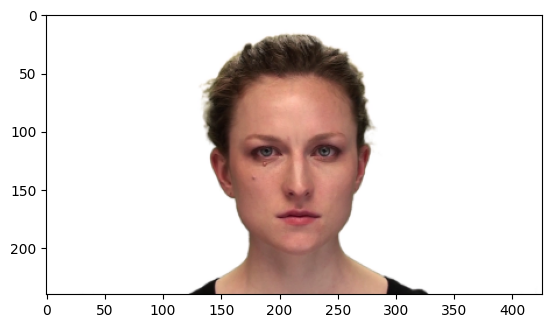

Processing Video_Speech_Actor_24.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


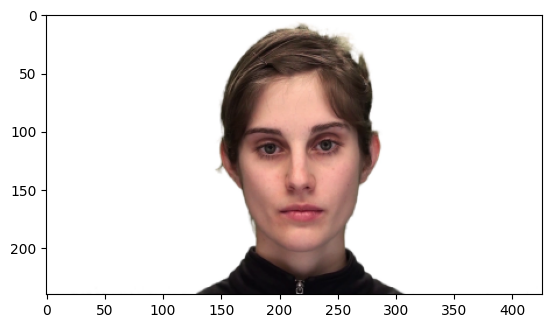

Processing Video_Speech_Actor_23.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


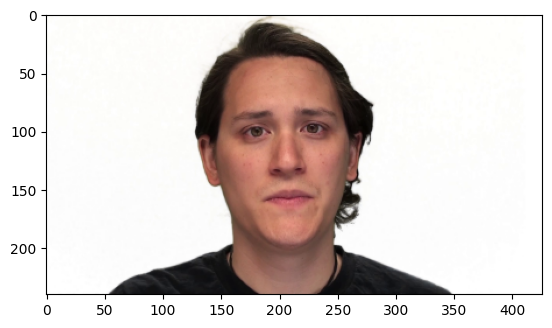

Processing Video_Speech_Actor_22.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


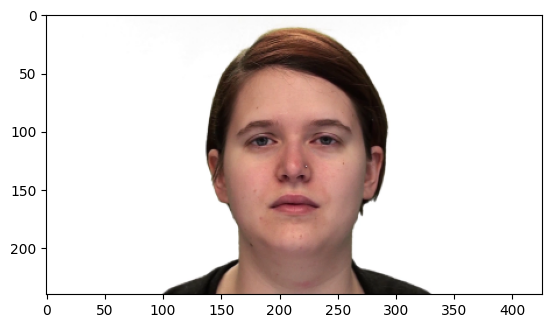

Processing Video_Speech_Actor_21.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


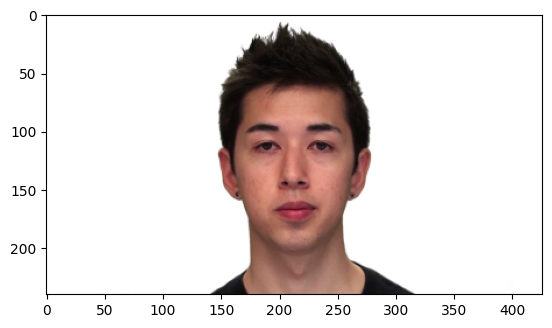

Processing Video_Speech_Actor_20.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


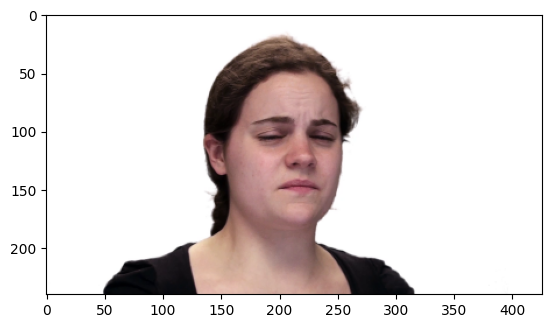

Processing Video_Speech_Actor_19.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


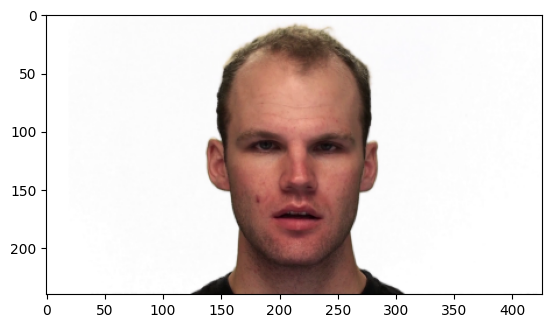

Processing Video_Speech_Actor_18.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


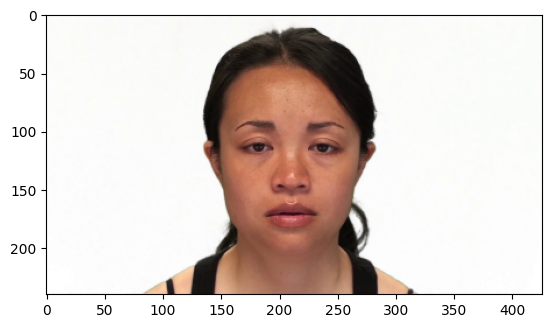

Processing Video_Speech_Actor_17.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


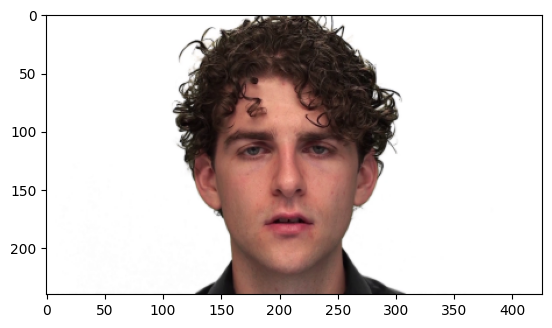

Processing Video_Speech_Actor_16.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


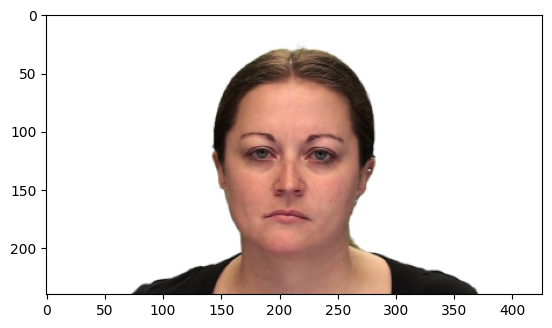

Processing Video_Speech_Actor_15.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


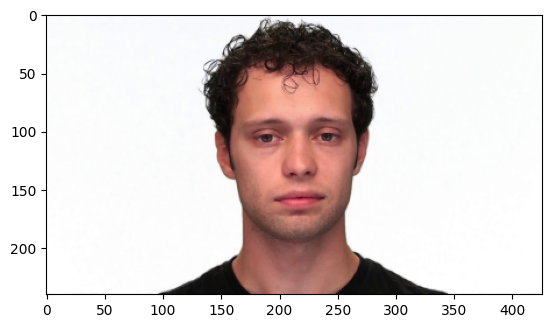

Processing Video_Speech_Actor_14.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


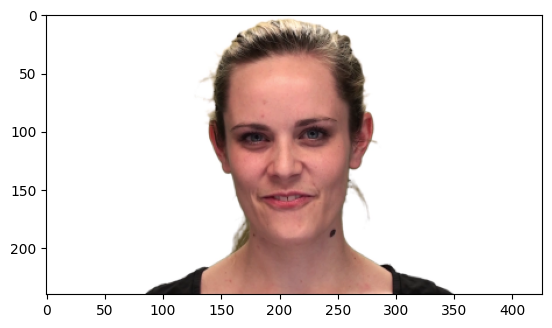

Processing Video_Speech_Actor_13.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


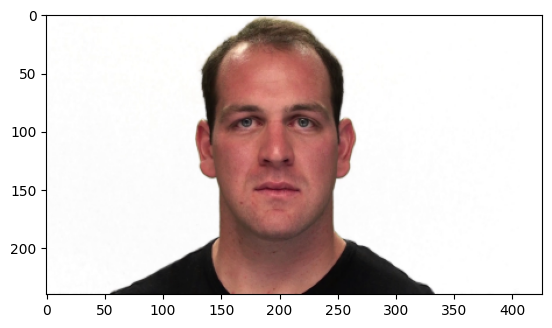

Processing Video_Speech_Actor_12.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


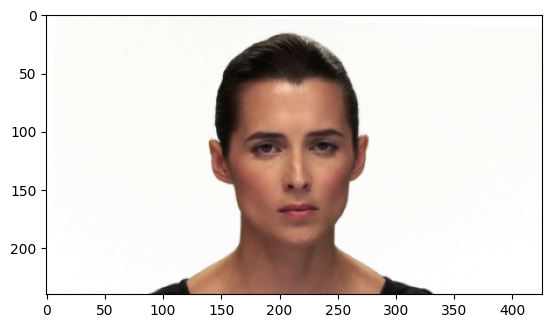

Processing Video_Speech_Actor_11.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


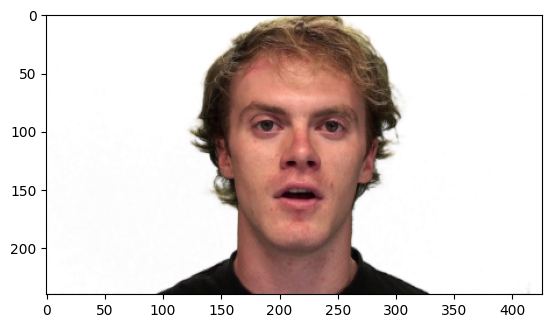

Processing Video_Speech_Actor_10.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


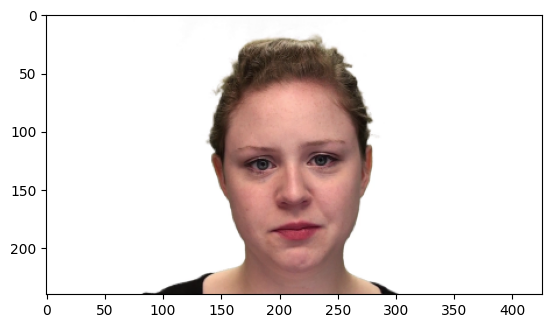

Processing Video_Speech_Actor_09.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


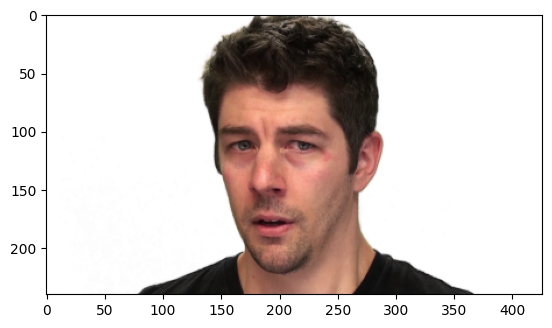

Processing Video_Speech_Actor_08.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


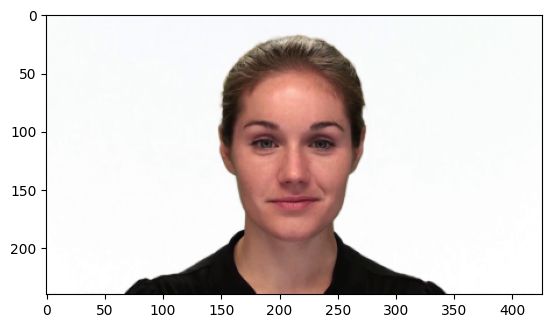

Processing Video_Speech_Actor_07.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


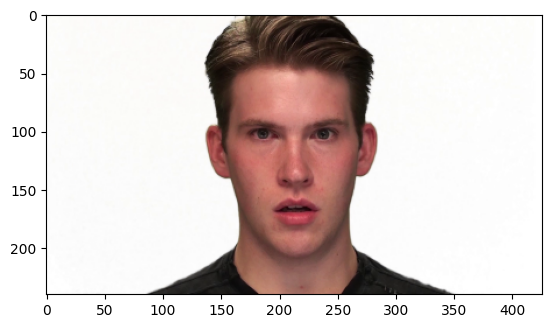

Processing Video_Speech_Actor_06.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


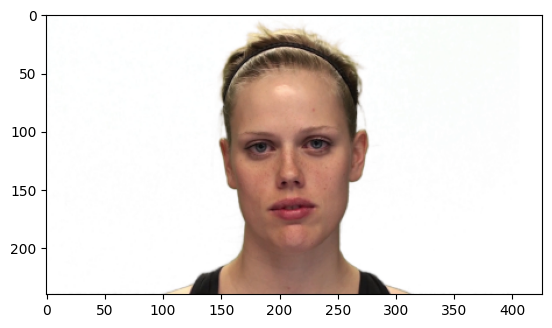

Processing Video_Speech_Actor_05.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


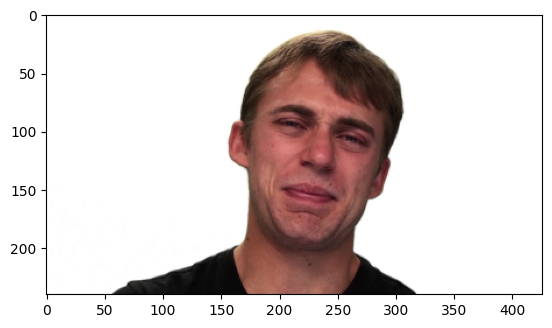

Processing Video_Speech_Actor_04.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


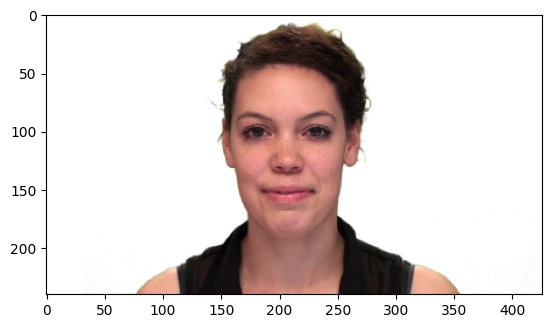

Processing Video_Speech_Actor_01.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


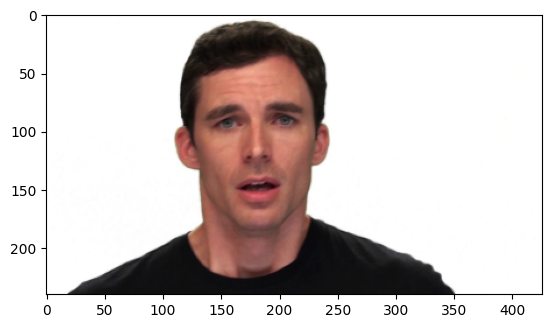

Processing Video_Speech_Actor_03.zip...


  0%|          | 0/120 [00:00<?, ?it/s]

Training Tensor Shape: (240, 426, 3, 50, 40)
Testing Tensor Shape: (240, 426, 3, 50, 20)


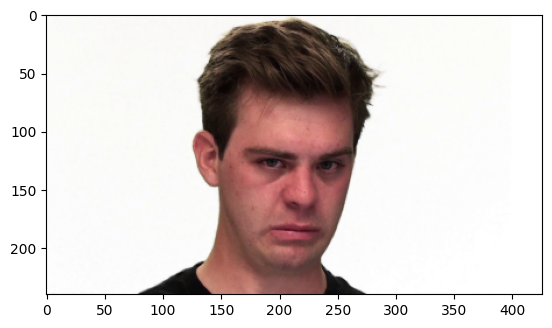

In [ ]:
folder_path = 'Speech'
target_frame_count = 50
scale_factor = 1/3

train_size = 40  # out of 60 videos (per actor)
test_size = 60 - train_size

train_shape = (int(720*scale_factor), int(1280*scale_factor), 3, target_frame_count, 24*train_size)
test_shape = (int(720*scale_factor), int(1280*scale_factor), 3, target_frame_count, 24*test_size)

train_videos = np.zeros(train_shape, dtype=np.uint8)
test_videos = np.zeros(test_shape, dtype=np.uint8)

id_train = np.zeros((24*train_size, 7), dtype=np.uint8)
id_test = np.zeros((24*test_size, 7), dtype=np.uint8)

i = 0
for zip_filename in tqdm(os.listdir(folder_path), desc='Total Progress'):
    if zip_filename.endswith(".zip") and zip_filename.startswith("Video"):
        zip_path = os.path.join(folder_path, zip_filename)
        print(f"Processing {zip_filename}...")
        training_tensor, training_identifier, testing_tensor, testing_identifier = \
            process_zip_file(zip_path, target_frame_count, scale_factor, train_size)

        print('Training Tensor Shape:', training_tensor.shape)
        print('Testing Tensor Shape:', testing_tensor.shape)

        train_videos[:, :, :, :, i*train_size:(i+1)*train_size] = training_tensor
        id_train[i*train_size:(i+1)*train_size, :] = training_identifier
        test_videos[:, :, :, :, i*test_size:(i+1)*test_size] = testing_tensor
        id_test[i*test_size:(i+1)*test_size, :] = testing_identifier

        plt.imshow(training_tensor[:, :, :, 0, 0]) # Showing a random frame from each actor's video tensors
        plt.show()
        del training_tensor
        del training_identifier
        del testing_tensor
        del testing_identifier

        gc.collect()


        i += 1

### Saving Data to Disk
Now that the data has been loaded, we can save it to drive and start our analysis!

In [ ]:
def save_to_disk(variable, filename):
    np.save(filename, variable)
    del variable
    gc.collect()

train_test_data_dir = os.path.join(os.getcwd(), 'Train_Test_Data')
os.makedirs(train_test_data_dir, exist_ok=True)

y_train = id_train[:, 2].astype(np.int8)
y_test = id_test[:, 2].astype(np.int8)

save_to_disk(train_videos, os.path.join(train_test_data_dir, 'train_videos.npy'))
save_to_disk(test_videos, os.path.join(train_test_data_dir, 'test_videos.npy'))
save_to_disk(y_train, os.path.join(train_test_data_dir, 'y_train.npy'))
save_to_disk(y_test, os.path.join(train_test_data_dir, 'y_test.npy'))
save_to_disk(id_train, os.path.join(train_test_data_dir, 'id_train.npy'))
save_to_disk(id_test, os.path.join(train_test_data_dir, 'id_test.npy'))